# Import Your Files

In [2]:
from astropy.io import fits
import os
import numpy as np
import matplotlib.pyplot as plt

# this is the directory containing fits files

fits_dir = "D:\\temp\\New folder\\tt3"

files = os.listdir(fits_dir)
os.listdir(fits_dir)

['fluor.fits',
 'fluor_1.fits',
 'fluor_2.fits',
 'fluor_3.fits',
 'fluor_4.fits',
 'fluor_5.fits',
 'fluor_6.fits',
 'fluor_7.fits',
 'fluor_8.fits',
 'lum.fits',
 'lum_1.fits',
 'lum_2.fits',
 'lum_3.fits',
 'lum_4.fits',
 'lum_5.fits',
 'lum_6.fits',
 'lum_7.fits',
 'lum_8.fits',
 'output']

In [3]:
os.chdir(fits_dir)

flour_files = ['fluor.fits', 'fluor_1.fits', 'fluor_2.fits', 'fluor_3.fits', 'fluor_4.fits', 'fluor_5.fits',
 'fluor_6.fits', 'fluor_7.fits', 'fluor_8.fits']

lum_files = ['lum.fits', 'lum_1.fits', 'lum_2.fits', 'lum_3.fits', 'lum_4.fits', 'lum_5.fits', 'lum_6.fits',
 'lum_7.fits', 'lum_8.fits']

f_stack = []
l_stack = []


# this for loop reads flourescence and luminescence files and store them in seperate lists.
for i in range(9):

    img = fits.open(flour_files[i])
    
    # average last ten frames
    img = np.mean(img[0].data[10:,:,:], axis=0)
    f_stack.append(img)
    
    img = fits.open(lum_files[i])
    l_stack.append(img[0].data[0,:,:])
    

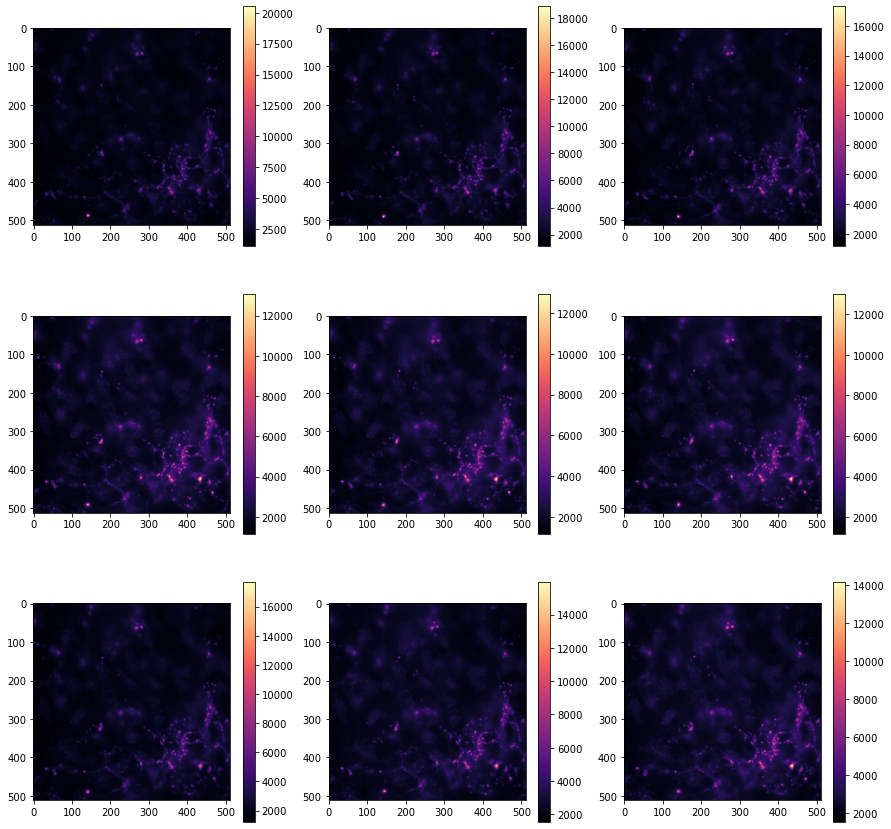

In [4]:
plt.figure(figsize=(15,15))

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(f_stack[i], cmap="magma")
    plt.colorbar()

# Kmeans clustering of luminescence images for finding background

In [6]:
from skimage.measure import block_reduce
from sklearn.cluster import KMeans

def cluster_lum(img, n = 4):
    
    # downsample images into 512/n x 512/n images through using median for n x n squares
    l_mean_down = block_reduce(img, (n,n), np.median)
    
    # cluster pixels into 2 clusters to find background
    pixel_values = l_mean_down.reshape(-1,1)
    kmeans = KMeans(n_clusters = 2, random_state = 42).fit(pixel_values)

    clusters = kmeans.labels_
    clusters = clusters.reshape((int(512/n),int(512/n)))
    
    bck = np.argmax(np.unique(clusters, return_counts=True)[1])
    clusters = np.where(clusters == bck, 0, 1)
    
    return clusters, l_mean_down
    

# Localizing cell body by finding the n by n square with the highest luminescence value

In [7]:
# Change d to adjust the size of localizer

def cell_body(img, d = 32, n = 4):

    img = block_reduce(img, (n,n), np.median)

    coordinates = []
    intensities = []

    for i in range(0, img.shape[0] - d):
        for j in range(0, img.shape[1] - d):

            intensity = np.mean(img[i : i + d, j : j + d])
            intensities.append(intensity)
            coordinates.append([i,j])


    cc = coordinates[np.argmax(intensities)]

    mask = np.zeros(img.shape)

    mask[cc[0]:cc[0]+d, cc[1]:cc[1]+d] = 1
    
    return mask

## quality check

In [17]:
def quality_check(image, mask, threshold = 300):
    if np.mean(image[mask == 1]) >= threshold:
        return "ok"
    else:
        return "check"

# Key Step: Visualize and Adjust Cell Body Masking If Needed

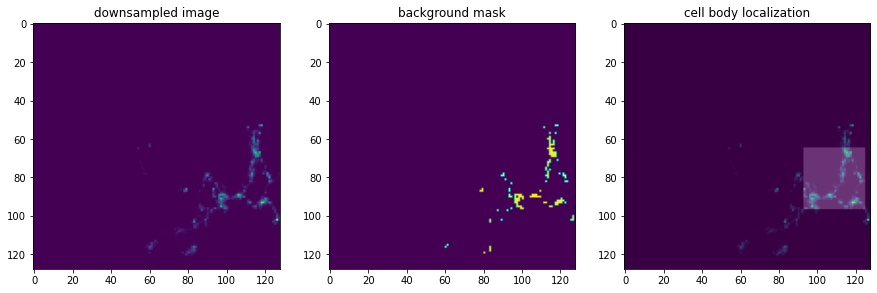

Are you satisfied with cell body mask Y/N: Y


In [8]:
from IPython.display import clear_output

# change d in this box to alter the cell body mask size 
mask, lum_down = cluster_lum(l_stack[2])
cb_mask = cell_body(l_stack[2], d = 32)

satisfied = "N"

while satisfied != "Y":
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.title("downsampled image")
    plt.imshow(lum_down)

    plt.subplot(1,3,2)
    plt.title("background mask")
    plt.imshow(mask)

    plt.subplot(1,3,3)
    plt.title("cell body localization")
    plt.imshow(lum_down)
    plt.imshow(cb_mask, alpha = 0.2, cmap = "hot")

    plt.show()

    satisfied = input("Are you satisfied with cell body mask Y/N: ")
    if(satisfied != "Y"):
        y = input("please type y coordinate: ")
        y = int(y)
        x = input("please type x coordinate: ")
        x = int(x)
        size = input("please type size of the box: ")
        size = int(size)
        clear_output()
        
        cb_mask = np.zeros(lum_down.shape)
        cb_mask[y:y+size, x:x+size] = 1

# change d in the next box to alter the cell body mask size in the analysis, after reviewing the image in this box

# Define Gain Level ( for FL 60, adjusted = True)

In [16]:
# With this function linear changes in the imaging due to hardware alteration can be defined. 
# for the images obtained with Flourescent Gain of 60, Adjusted = True

import matplotlib

#saving png files in a subfolder under the original fits_dir
png_dir = os.path.join(fits_dir, "output")

save_png = True

if save_png == True:
    newpath = png_dir
    if not os.path.exists(newpath):
        os.makedirs(newpath)


lf_list = []
lum_list = []
fluor_list = []
lq_list = []
fq_list = []
n = 4
#d = 10
adjusted = True

for i in range(9):
    #cb_mask = cell_body(l_stack[i], d)
    c, l = cluster_lum(l_stack[i])
    bck = np.mean(l[c == 0])
    l = l - bck
    l = np.where(l > 0, l , 0)
    
    
    f = block_reduce(f_stack[i], (n,n), np.median)
    bck = np.mean(f[c == 0])
    
    # adjusted = True : F for Flourescent Gain 60 of Andor Software
    if adjusted == True:
        f = (f-bck)/2.9201091
    else:
        f = f - bck
    f = np.where(f > 0 , f, 0)
    
    c = np.where(cb_mask == 1, 0, c)
    
    r = np.mean(l[c == 1])/np.mean(f[c == 1])
    
    
    #saving images
    if save_png == True:
        
        matplotlib.image.imsave(os.path.join(newpath, "fluorescence" + str(i + 1) + ".png"), f_stack[i])
        matplotlib.image.imsave(os.path.join(newpath, "luminescence" + str(i + 1) + ".png"), l_stack[i])
        
        matplotlib.image.imsave(os.path.join(newpath, "fluorescence_masked" + str(i + 1) + ".png"), f * c)
        matplotlib.image.imsave(os.path.join(newpath, "luminescence_masked" + str(i + 1) + ".png"), l * c)
    
    #quality check
    lq = quality_check(l, c, threshold=300)
    fq = quality_check(f, c, threshold=300)
    

    lf_list.append(r)
    lum_list.append(np.mean(l[c == 1]))
    fluor_list.append(np.mean(f[c == 1]))
    lq_list.append(lq)
    fq_list.append(fq)
    
    print(r, np.mean(l[c == 1]), np.mean(f[c == 1]), lq, fq)

1.085336797429843 680.4291730046527 626.929055216739 ok ok
1.1017882695826764 738.6260234150859 670.3883530134649 ok ok
1.0627588247412532 674.7880940120282 634.9400054864911 ok ok
1.0305255986423956 531.8855738436904 516.1303848680627 ok ok
0.7909894356737845 394.3004414931345 498.49014880617153 ok ok
0.7831995859108838 443.60366631859847 566.3992605443918 ok ok
0.8857137127612402 533.5801964497508 602.4296437573466 ok ok
0.9506435893152987 553.6863437328952 582.4331536613927 ok ok
1.0879642378559455 538.4856822624074 494.9479620061803 ok ok


# Results

In [127]:
#L/F Total Synaptic ATP levels
lf_list

[0.9412314095933157,
 0.975027980297802,
 0.9066638983433339,
 0.8572844560847216,
 0.6277719073355252,
 0.6433609525479707,
 0.7303320402490467,
 0.8423580295185494,
 0.806457704650389]

Text(0, 0.5, 'intensity')

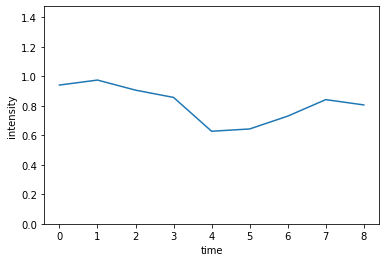

In [128]:
plt.plot(lf_list)

plt.ylim(0,np.max(lf_list)+0.5)
plt.xlabel("time")
plt.ylabel("intensity")

# save output file to a MS Excel file 

In [ ]:
import pandas as pd 

output_df = pd.DataFrame([lf_list, lum_list, fluor_list, lq_list, fq_list]).transpose()
output_df.columns = ["L/F", "L", "F", "L_Quality", "F_Quality"]

output_df

# file's name will be the same as its folder name
file_name = fits_dir.split("\\")[-1] + ".xlsx"

# Files will be saved in this location
destination_folder = "C:\\......\\Excel files"

file_location = destination_folder + "\\" + file_name

output_df.to_excel(file_location)